# Dependencias

In [6]:
import numpy as np
import pandas as pd

from sklearn.linear_model import PassiveAggressiveClassifier, LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.feature_selection import f_regression, SelectKBest, VarianceThreshold
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, confusion_matrix, r2_score, mean_absolute_error, roc_auc_score
from scikitplot.metrics import plot_roc

from varclushi import VarClusHi
from scipy import stats
from datetime import datetime, date

import matplotlib.pyplot as plt
import cufflinks as cf
import seaborn as sns

cf.go_offline()
pd.set_option('display.max_columns',None)

# Lectura de datos

In [74]:
ruta='/home/oscarjarillo/Documentos/Análisis Multivariado/Varios/ADO April 2023 - Inflation.csv'
df=pd.read_csv(ruta, encoding_errors='ignore')
df.head()

,RegionalMember,Year,Inflation,Unit of Measurement,Subregion,Country Code
0,Developing Asia,2018,2.7,%,NaN,NaN
1,Developing Asia,2019,3.2,%,NaN,NaN
2,Developing Asia,2020,3.3,%,NaN,NaN
3,Developing Asia,2021,2.6,%,NaN,NaN
4,Developing Asia,2022,4.4,%,NaN,NaN


In [75]:
df.shape

(371, 6)

In [76]:
df.drop('Unit of Measurement',axis=1,inplace=True)
df.rename(columns={'Inflation':'Inflation %',' Subregion':'Subregion',' Country Code':'Country Code'},inplace=True)

In [77]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 371 entries, 0 to 370
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   RegionalMember  371 non-null    object 
 1   Year            371 non-null    object 
 2   Inflation %     365 non-null    float64
 3   Subregion       357 non-null    object 
 4   Country Code    322 non-null    object 
dtypes: float64(1), object(4)
memory usage: 14.6+ KB


# Datos para entrenar y predecir

In [274]:
X = df[(df['Year']!='2023 forecast')&(df['Year']!='2024 forecast')]
X.insert(0,'id',X.index+1)

In [275]:
Xp = df[(df['Year']=='2023 forecast')|(df['Year']=='2024 forecast')]
Xp.insert(0,'id',Xp.index+1)

# Definición de variables

In [276]:
um = ['id']
vart = ['Inflation %']
varc = ['Year']
vard = ['RegionalMember','Subregion','Country Code']

# Análisis exploratorio

In [277]:
for v in varc:
    X[v] = pd.to_numeric(X[v])

In [278]:
for v in vard:
    for a,b in zip(list(X[v].dropna().unique()),range(1,len(list(X[v].dropna().unique()))+1)):
        X.loc[X[v]==a,v]=b
    X[v] = pd.to_numeric(X[v],errors='ignore')

In [279]:
var = varc+vard

## Valores nulos

In [280]:
nulos = 1-X.describe().T[['count']]/len(X)
nulos

,count
id,0.000000
RegionalMember,0.000000
Year,0.000000
Inflation %,0.007547
Subregion,0.037736
Country Code,0.132075


In [281]:
X.dropna(subset=vart[0],inplace=True)

In [282]:
nulos = 1-X.describe().T[['count']]/len(X)
nulos

,count
id,0.000000
RegionalMember,0.000000
Year,0.000000
Inflation %,0.000000
Subregion,0.038023
Country Code,0.133080


In [283]:
sm = SimpleImputer(strategy='median')
sm.fit(X)

SimpleImputer(strategy='median')

In [284]:
Xi = pd.DataFrame(sm.transform(X),columns=X.columns)

In [291]:
ks = pd.DataFrame(map(lambda v:(v,stats.ks_2samp(Xi[v],X[v].dropna()).statistic),var),
                  columns=['var','ks']).set_index('var').sort_values(by='ks',ascending=False)
ks

,ks
var,
Country Code,0.065956
Subregion,0.018035
Year,0.000000
RegionalMember,0.000000


In [294]:
var = [v for v in ks.index if ks['ks'][v]<0.05 ]
var

['Subregion', 'Year', 'RegionalMember']

## Varianza nula

In [307]:
vt = VarianceThreshold()
vt.fit(Xi[var])

VarianceThreshold()

In [308]:
fuera = [a for a,b in zip(var+['prueba'],vt.get_support()) if not b]
fuera

[]

## Selección de variables con mejor poder predictivo

In [310]:
sk = SelectKBest(k=len(var),score_func=f_regression)
sk.fit(Xi[var],Xi[vart[0]])

SelectKBest(k=3, score_func=<function f_regression at 0x7f61b9c5a560>)

In [311]:
pd.DataFrame(zip(var,sk.scores_),columns=['var','score']).set_index('var').sort_values(by='score',
                                ascending=False).iplot(kind='bar',color='orange')

In [312]:
sk = SelectKBest(k=len(var),score_func=f_regression)
sk.fit(Xi[var],Xi[vart[0]])

SelectKBest(k=3, score_func=<function f_regression at 0x7f61b9c5a560>)

In [313]:
best = [a for a,b in zip(var,sk.get_support())if b]
best

['Subregion', 'Year', 'RegionalMember']

## Multicolinealidad

In [320]:
vc = VarClusHi(Xi,feat_list=best).varclus().rsquare.sort_values(by=['Cluster','RS_Ratio']).reset_index(drop=True)
display(vc)

,Cluster,Variable,RS_Own,RS_NC,RS_Ratio
0,0,RegionalMember,0.939004,0,0.060996
1,0,Subregion,0.938983,0,0.061017
2,0,Year,0.000456,0,0.999544


## Valores extremos

array([[<AxesSubplot:title={'center':'Subregion'}>,
        <AxesSubplot:title={'center':'Year'}>],
       [<AxesSubplot:title={'center':'RegionalMember'}>, <AxesSubplot:>]],
      dtype=object)

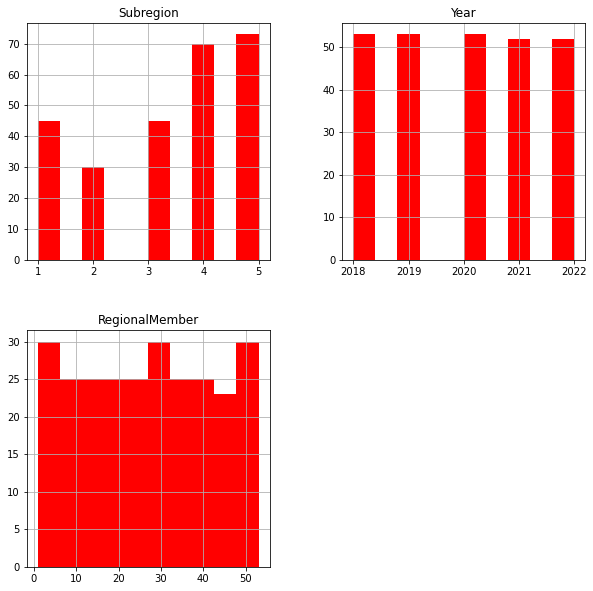

In [322]:
Xi[best].hist(figsize=(10,10),color='red')

In [323]:
for v,li,ls in Xi[best].describe(percentiles=[0.01,0.99]).T[['1%','99%']].reset_index().values:
    Xi[f'ex_{v}'] = ((Xi[v]<li)|(Xi[v]>ls)).astype(int)
Xi['ex_'] = Xi.filter(like='ex_').max(axis=1)
Xi['ex_'].value_counts(1)

0    1.0
Name: ex_, dtype: float64

In [325]:
Xi = Xi.loc[Xi['ex_']==0].drop(Xi.filter(like='ex_').columns,axis=1)

array([[<AxesSubplot:title={'center':'Subregion'}>,
        <AxesSubplot:title={'center':'Year'}>],
       [<AxesSubplot:title={'center':'RegionalMember'}>, <AxesSubplot:>]],
      dtype=object)

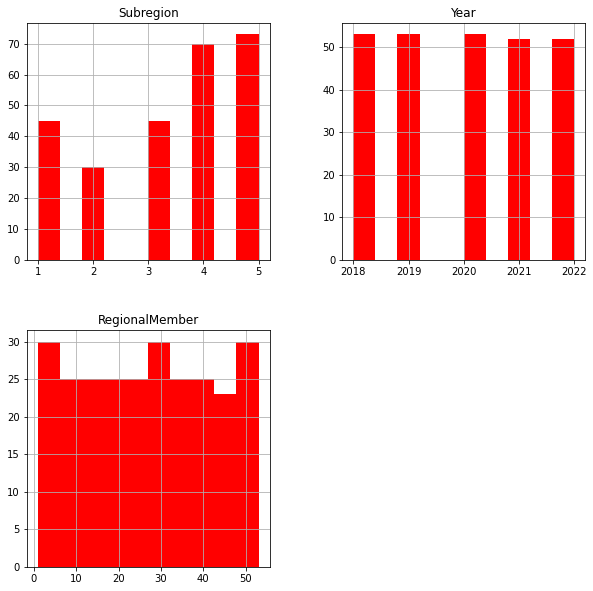

In [327]:
Xi[best].hist(figsize=(10,10),color='red')

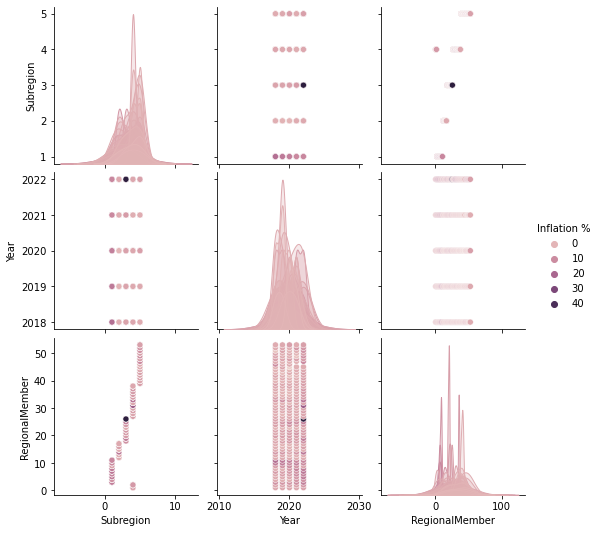

In [336]:
sns.pairplot(data=Xi[best+vart],hue=vart[0])

## Cambio de espacio $\mathcal{X}_{[0,1]}$

In [328]:
sc = MinMaxScaler()
sc.fit(Xi[best])

MinMaxScaler()

In [329]:
X01 = pd.DataFrame(sc.transform(Xi[best]),columns=best)
X01[um+vart] = Xi[um+vart]

# Partición de entrenamiento

In [334]:
Sn, Sv = train_test_split(X01[best+vart],train_size=0.7)
Sn.reset_index(drop=True,inplace=True)
Sv.reset_index(drop=True,inplace=True)

# Aprendizaje

## Regresión Cresta

In [349]:
hp = dict(alpha=np.arange(0.1,3,0.1))
modelo=Ridge()
grid = GridSearchCV(param_grid=hp,
                   cv=5,
                   scoring='neg_mean_absolute_error',
                   n_jobs=-1,
                   verbose=True,
                   estimator=modelo)

In [350]:
grid.fit(Sn[best],Sn[vart[0]])

Fitting 5 folds for each of 29 candidates, totalling 145 fits


GridSearchCV(cv=5, estimator=Ridge(), n_jobs=-1,
             param_grid={'alpha': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3,
       1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5, 2.6,
       2.7, 2.8, 2.9])},
             scoring='neg_mean_absolute_error', verbose=True)

In [351]:
grid.best_params_

{'alpha': 2.9000000000000004}

In [352]:
modelo = grid.best_estimator_
modelo

Ridge(alpha=2.9000000000000004)

In [353]:
modelo.fit(Sn[best],Sn[vart[0]])

Ridge(alpha=2.9000000000000004)

### Validación del modelo

In [354]:
Sn['y^'] = modelo.predict(Sn[best])
Sv['y^'] = modelo.predict(Sv[best])

In [355]:
print(mean_absolute_error(y_pred=Sn['y^'],y_true=Sn[vart[0]]))
print(mean_absolute_error(y_pred=Sv['y^'],y_true=Sv[vart[0]]))

2.2541148686996526
3.180469146535081


In [356]:
print(r2_score(y_pred=Sn['y^'],y_true=Sn[vart[0]]))
print(r2_score(y_pred=Sv['y^'],y_true=Sv[vart[0]]))

0.28862490953093045
0.10869210998937884


<AxesSubplot:ylabel='Density'>

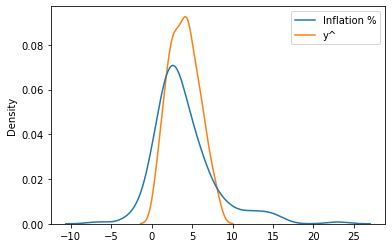

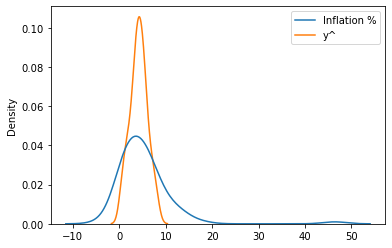

In [357]:
plt.figure()
sns.kdeplot(data=Sn[vart+['y^']])
plt.figure()
sns.kdeplot(data=Sv[vart+['y^']])

In [359]:
Sn.head()

,Subregion,Year,RegionalMember,Inflation %,y^
0,0.75,0.75,0.653846,2.3,4.364076
1,0.00,0.50,0.057692,1.2,6.232656
2,0.25,0.75,0.307692,2.0,6.179056
3,0.25,1.00,0.250000,15.2,7.134454
4,1.00,0.50,0.923077,1.5,2.472186


## Regresión lineal

In [360]:
modelo = LinearRegression(n_jobs=-1)
modelo.fit(Sn[best],Sn[vart[0]])

LinearRegression(n_jobs=-1)

### Validación del modelo

In [361]:
Sn['y^'] = modelo.predict(Sn[best])
Sv['y^'] = modelo.predict(Sv[best])

In [362]:
print(mean_absolute_error(y_pred=Sn['y^'],y_true=Sn[vart[0]]))
print(mean_absolute_error(y_pred=Sv['y^'],y_true=Sv[vart[0]]))

2.2630792641657984
3.1703348256063775


In [363]:
print(r2_score(y_pred=Sn['y^'],y_true=Sn[vart[0]]))
print(r2_score(y_pred=Sv['y^'],y_true=Sv[vart[0]]))

0.29317446886580334
0.1206920155196397


<AxesSubplot:ylabel='Density'>

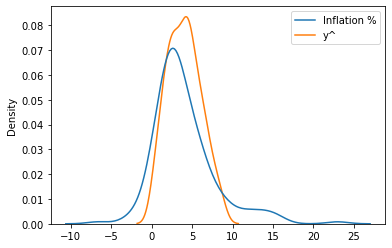

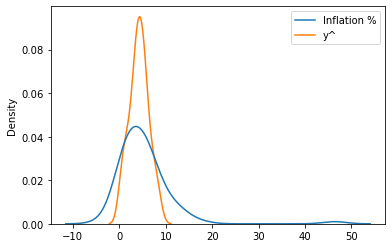

In [364]:
plt.figure()
sns.kdeplot(data=Sn[vart+['y^']])
plt.figure()
sns.kdeplot(data=Sv[vart+['y^']])